<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [3]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8
To: /content/clothing_ecommerce_reviews.csv
100%|██████████| 8.48M/8.48M [00:00<00:00, 36.7MB/s]


In [4]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [5]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


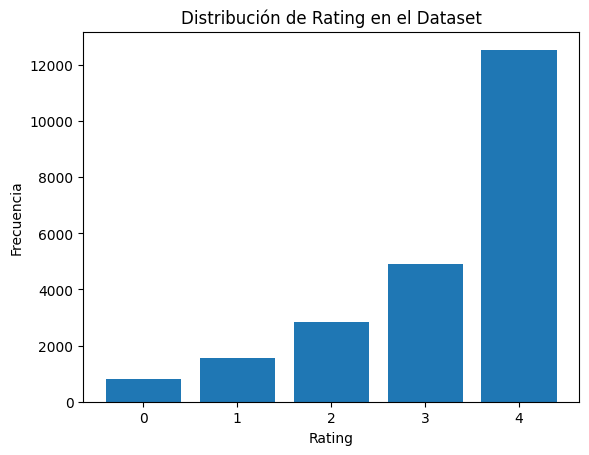

In [6]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase
# Contar la frecuencia de cada clase en la columna 'Rating'
rating_counts = df_reviews['Rating'].value_counts()

# Crear un gráfico de barras para visualizar la distribución
plt.bar(rating_counts.index, rating_counts.values)
plt.xlabel('Rating')
plt.ylabel('Frecuencia')
plt.title('Distribución de Rating en el Dataset')
plt.show()

# Calcular el porcentaje de cada clase respecto al total
class_percentages = rating_counts / len(df) * 100

In [9]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews

reviews_np = np.array(df_reviews['Review Text'])

In [11]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
len((df_reviews.drop_duplicates())['Review Text'])

22634

In [14]:
# Alumno: Concatenar todas las reviews para armar el corpus
corpus = ' '.join(df_reviews['Review Text'].astype(str))

In [15]:
# Alumno: ¿Cuál es la longitud de ese corpus?
len(corpus)

7011643

In [16]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence
tokens = text_to_word_sequence(corpus)

In [18]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
tokens[0:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [19]:
# Alumno: ¿Cuántos tokens/palabras hay?
len(tokens)

1372203

In [21]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words
# Crear una instancia del Tokenizer
tokenizer = Tokenizer(num_words=num_words)

# Obtener las reviews como una lista de textos
#reviews = df['Review'].astype(str).tolist()

# Ajustar el Tokenizer en los textos
#tokenizer.fit_on_texts(reviews)

# Obtener la representación de secuencia de las reviews
#sequences = tokenizer.texts_to_sequences(reviews)

In [47]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
# Ajustar el Tokenizer en los textos
tokenizer.fit_on_texts(corpus)

# Obtener el diccionario de palabra a índice
word_index = tokenizer.word_index

# Obtener la cantidad total de palabras en el vocabulario
vocab_size = len(word_index)
# Imprimir la cantidad total de palabras en el vocabulario
print("Cantidad total de palabras en el vocabulario:", vocab_size)

Cantidad total de palabras en el vocabulario: 13499


In [24]:
# Alumno: Convertir las palabras/tokens a números
# Convertir las palabras a números usando el diccionario de palabra a índice
sequences = tokenizer.texts_to_sequences(corpus)

# Imprimir las secuencias numéricas correspondientes a las reviews
for i, sequence in enumerate(sequences):
    print(f"Review {i+1}: {sequence}")

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Review 12235: [3, 413, 365, 29, 210, 28, 32, 97, 3, 45, 21, 504, 1443, 1998, 28, 42, 164, 43, 1156, 450, 3, 21, 36, 245, 498, 259, 72, 915, 290, 29, 21, 96, 751, 3, 37, 382, 451, 29, 558, 28, 42, 32, 97, 25, 98, 185, 351, 29, 21, 76, 449, 32, 21, 42, 122, 4, 47, 91, 51, 184, 21, 238, 21, 1040, 184, 773, 26, 479, 36, 4, 1973, 24, 233, 21, 832, 3, 878, 90, 159, 352, 6, 14, 10, 38, 3, 421, 41, 215, 130, 119, 1611]
Review 12236: [3, 45, 30, 1653, 176, 25, 26, 140, 461, 4, 65, 4, 24, 28, 37, 187, 4, 3, 66, 1198, 174, 25, 160, 308, 55, 3, 1565, 28, 587, 21, 830, 440, 183, 32, 56, 3, 66, 470, 24, 143, 24, 3, 104, 21, 112, 161, 305, 29, 686, 32]
Review 12237: [384, 197, 1455, 28, 42, 33, 4, 277, 1952, 82, 25, 151, 135, 33, 56, 3, 74, 562, 21, 1527, 46, 107, 25, 244, 32, 190, 275, 132, 87, 3, 66, 24, 1198, 782, 195, 25, 111, 92, 82, 4, 559, 208, 30, 21, 127, 31, 3, 133, 82, 3, 98, 172, 21, 1092, 25, 297, 54, 63, 396, 233, 21, 23

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Review 21233: [556, 38, 100, 62, 119, 43, 63, 147, 111, 4, 530, 208, 31, 47, 132, 24, 305, 29, 59, 311, 262, 91, 231, 166, 36, 4, 559, 35, 410, 24, 21, 131, 111, 67, 55, 25, 640, 32, 21, 186]
Review 21234: [3, 66, 483, 24, 59, 347, 4, 265, 316, 749, 24, 14, 10, 248, 726, 3, 71, 1022, 595, 4, 930, 1259, 3, 49, 4, 735, 1713, 24, 592, 780, 664, 33, 28, 3, 85, 4, 130, 24, 25, 37, 288, 208, 38, 82, 69, 52, 143, 204, 1713, 562, 204, 407, 46, 88, 314, 54, 329, 21, 76, 26, 47, 408, 53, 4, 407, 1333, 2, 113, 71, 54, 145, 95, 35, 67, 29, 289, 30, 688, 21, 1860, 26, 84, 484, 191, 3, 71, 67, 314, 750, 397, 537, 918, 65, 82]
Review 21235: [236, 839, 21, 255, 3, 352, 114, 29, 4, 81, 449, 3, 273, 25, 3, 196, 21, 76, 24, 79, 176, 25, 37, 38, 1909, 383, 60, 53, 21, 1158, 157, 134, 574, 1519, 24, 660, 4, 1528, 29, 223, 28, 50, 63, 302, 3, 373, 25, 38, 117, 44, 3, 352, 149, 114, 29, 4, 77, 24, 25, 158, 51, 25, 26, 63, 302, 24, 43, 123, 182, 220, 52, 207, 96]
Review 21236: [3, 98, 28, 32, 41, 258, 55, 724

In [26]:
# Alumno: Determinar cual es la oración más larga
# Obtener la longitud de cada secuencia
lengths = [len(seq) for seq in sequences]

# Encontrar el índice de la oración más larga
max_length_index = lengths.index(max(lengths))

# Obtener la oración más larga
longest_sentence = corpus[max_length_index]
# Imprimir la oración más larga y su longitud
print("Oración más larga:")
print(longest_sentence)
print("Longitud:", max(lengths))

Oración más larga:
a
Longitud: 115


In [27]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from tensorflow.keras.utils import pad_sequences
maxlen = 115
# Realizar el padding de las secuencias al mismo tamaño
padded_sequences = pad_sequences(sequences, maxlen=maxlen)

In [29]:
# Alumno: Observar las dimensiones de la variable input
input_shape = padded_sequences.shape
input_shape

(22641, 115)

In [30]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)
y = to_categorical(df_reviews["Rating"], num_classes=5)

# Imprimir la shape de y
print("Shape de y:", y.shape)

Shape de y: (22641, 5)


In [31]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split

X = padded_sequences
y = y

# Dividir los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Alumno: determinar la dimensiones de entrada y salida
print("Shape de X_train:", X_train.shape)
print("Shape de X_test:", X_test.shape)
print("Shape de y_train:", y_train.shape)
print("Shape de y_test:", y_test.shape)

Shape de X_train: (18112, 115)
Shape de X_test: (4529, 115)
Shape de y_train: (18112, 5)
Shape de y_test: (4529, 5)


### 2 - Rearmamos un poco el codigo anterior y entrenamos el modelo con Embeddings + LSTM

In [45]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# Datos de entrada (X) y la variable de salida (y)

X = df_reviews['Review Text']
y = df_reviews['Rating']

# Dividimos los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creamos una instancia del Tokenizer y ajustamos en los textos
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convertimos las palabras a secuencias de números
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Obtenemos la longitud máxima de una secuencia
max_length = max([len(seq) for seq in X_train_seq])

# Realizamos el padding de las secuencias al mismo tamaño
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

# Obtenemos el número total de palabras
num_words = len(tokenizer.word_index) + 1

# Convertimos las etiquetas a one-hot encoding
y_train_onehot = to_categorical(y_train, num_classes=5)
y_test_onehot = to_categorical(y_test, num_classes=5)

# Aplicamos sobremuestreo para balancear las categorías
ros = RandomOverSampler(random_state=42)
X_train_pad_resampled, y_train_onehot_resampled = ros.fit_resample(X_train_pad, y_train_onehot)

# Definimos el modelo
embedding_dim = 100
model = Sequential()
model.add(Embedding(num_words, embedding_dim, input_length=max_length))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))

# Compilamos el modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenamos el modelo con los datos sobremuestreados
history=model.fit(X_train_pad_resampled, y_train_onehot_resampled, validation_data=(X_test_pad, y_test_onehot), epochs=3, batch_size=32)

# Evaluamos el modelo
loss, accuracy = model.evaluate(X_test_pad, y_test_onehot)
print("Loss:", loss)
print("Accuracy:", accuracy)


Epoch 1/3
1562/1562 [==============================] - 832s 530ms/step - loss: 0.8846 - accuracy: 0.6234 - val_loss: 1.1086 - val_accuracy: 0.5657
Epoch 2/3
1562/1562 [==============================] - 815s 522ms/step - loss: 0.4538 - accuracy: 0.8242 - val_loss: 1.2761 - val_accuracy: 0.5904
Epoch 3/3
142/142 [==============================] - 6s 40ms/step - loss: 1.4583 - accuracy: 0.5630
Loss: 1.4582890272140503
Accuracy: 0.563038170337677


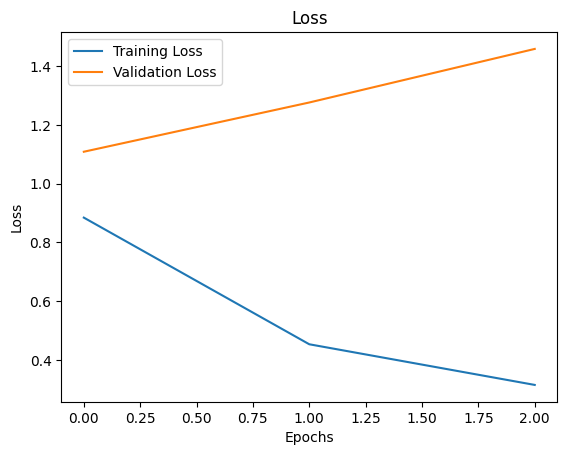

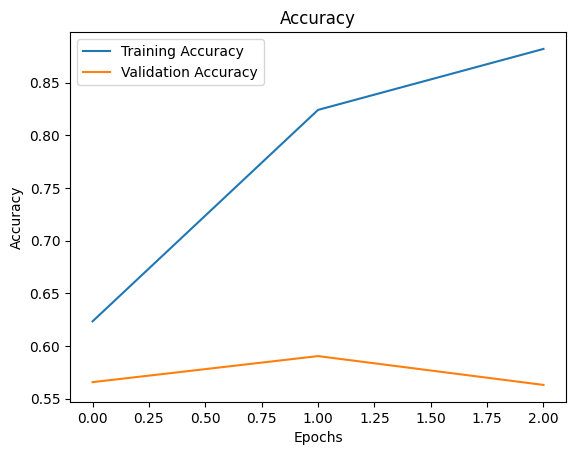

In [46]:
import matplotlib.pyplot as plt

# Historia de entrenamiento
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# La pérdida
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# La precisión
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
